In [1]:
%matplotlib inline

# TODO: update Postgres Git :)

In [28]:
import re
import sqlite3
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

con = sqlite3.connect('main.db')

project_name = 'postgres'

sql = f'''
select tag, date(creator_dt)
from projects join releases on projects.id = releases.project_id
where name = '{project_name}'

'''
# and tag like 'REL_%' and tag not like 'REL2%'
# and tag not like 'release%'
# and tag not like '%ALPHA%'
# and tag not like '%beta%'
# and tag not like '%RC%'
raw_releases = con.execute(sql).fetchall()

def is_interesting(rtag):
    major_minor = re.compile(r'^REL[0-9]_[0-9]+$')
    recent_mm = re.compile(r'^REL_1')
    return bool(major_minor.match(rtag) or recent_mm.match(rtag))

# TODO: use semver library?
def is_major(version):
    # note: "REL" prefix stripped
    major3 = re.compile(r'^[0-9]+.0.0$')  # "7.0.0"
    major2 = re.compile(r'^[0-9]+.0$')      # "10.0" (no micro)
    return bool(major2.match(version) or major3.match(version))

def strip_prefix(rtag):
    return rtag.lstrip('REL_')  # note: strip chars, not string

print(f'raw: {len(raw_releases)}')
print(raw_releases[:5] + raw_releases[-5:])
print()

# for row in raw_releases[:10] + raw_releases[-10:]:
#     print(f'{row[0]:10} {row[1]} {is_interesting(row[0])}')

releases = list(rel for rel in raw_releases if is_interesting(rel[0]))
print(f'rel: {len(releases)}')
print([row[0] for row in releases])
# print(releases[:5] + releases[-5:])
print()

names = [strip_prefix(row[0]) for row in releases]
dates = [row[1] for row in releases]
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
print(dates[:3])

raw: 476
[('PG95-1_01', '1996-07-09'), ('PG95-1_08', '1996-10-04'), ('PG95-1_09', '1996-10-31'), ('REL2_0', '1996-12-09'), ('REL6_1', '1997-06-13'), ('REL_12_BETA1', '2019-05-20'), ('Release_1_0_2', '1996-08-02'), ('Release_2_0', '1996-08-14'), ('Release_2_0_0', '1996-08-17'), ('release-6-3', '1998-03-02')]

rel: 34
['REL2_0', 'REL6_1', 'REL6_2', 'REL6_3', 'REL6_5', 'REL7_0', 'REL7_1', 'REL7_2', 'REL7_3', 'REL7_4', 'REL_10_0', 'REL_10_1', 'REL_10_2', 'REL_10_3', 'REL_10_4', 'REL_10_5', 'REL_10_6', 'REL_10_7', 'REL_10_8', 'REL_10_BETA1', 'REL_10_BETA2', 'REL_10_BETA3', 'REL_10_BETA4', 'REL_10_RC1', 'REL_11_0', 'REL_11_1', 'REL_11_2', 'REL_11_3', 'REL_11_BETA1', 'REL_11_BETA2', 'REL_11_BETA3', 'REL_11_BETA4', 'REL_11_RC1', 'REL_12_BETA1']

[datetime.datetime(1996, 12, 9, 0, 0), datetime.datetime(1997, 6, 13, 0, 0), datetime.datetime(1997, 10, 2, 0, 0)]


[(datetime.datetime(1997, 6, 13, 0, 0), -5, '6_1'), (datetime.datetime(1997, 10, 2, 0, 0), 5, '6_2'), (datetime.datetime(1998, 3, 2, 0, 0), -3, '6_3')]
6_1 False
6_2 False
6_3 False
6_5 False
7_0 True
7_1 False
7_2 False
7_3 False
7_4 False
10_0 True
10_1 False
10_2 False
10_3 False
10_4 False
10_5 False
10_6 False
10_7 False
10_8 False
11_0 True
11_1 False
11_2 False
11_3 False


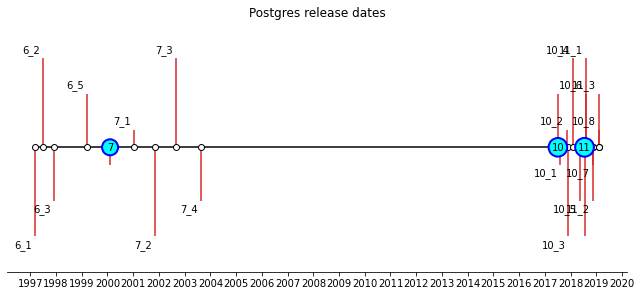

<Figure size 432x288 with 0 Axes>

In [17]:
# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="black", markerfacecolor="white")  # Baseline and markers on it.

releases = list(zip(dates, levels, names))
print(releases[:3])

# annotate minor releases with lines
min_style = dict(textcoords="offset points",
                horizontalalignment="right")
for a_date, a_level, name in releases:
        if is_major(name):
                continue
        ax.annotate(name, xy=(a_date, a_level),
                xytext=(-3, np.sign(a_level)*3),
                verticalalignment="bottom" if a_level > 0 else "top",
                **min_style)

# major release gets big blue circle
major_style = dict(
        size=10, ha="center", va="center", # rotation=45, 
        bbox=dict(boxstyle="circle,pad=0.3", fc="cyan", ec="b", lw=2)
)
for a_date, a_level, name in releases:
        print(name, is_major(name))
        if not is_major(name):
                continue
        major_name = re.match('[0-9]+', name).group(0) # major version only
        t = ax.text(
                a_date, 0, major_name, 
                **major_style)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set(title=f"{project_name.title()} release dates")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.2)

plt.show()

plt.savefig(f"{project_name}-releases.png")